In [5]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 6.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=cf4004eeb48c3ff4adb650a025976750ddc820dc6bb07159208bd01d3b5ebf23
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 1.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:


In [6]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 5.3 MB/s 
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 130 kB 44.1 MB/s 
     |████████████████████████████████| 151 kB 8.1 MB/s 
     |████████████████████████████████| 843 kB 60.4 MB/s 
     |████████████████████████████████| 117 kB 75.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=3a9f4e6c1f81d5f42db19f4d9d508b5aa5abd67310c97aaaa4aa1f2331fb2033
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=1cf018fa9f135581c806

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
classes = ['bean']

data_path = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

#Training the Detectron2 Instance Segmentation Model


In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [5]:
output_dir = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean'
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = output_dir # unutma output_dir tanımla ki model ve cfg aynı yerde olsun dikkat et!(pickle)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[07/09 14:36:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 63.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

In [8]:
trainer.train()

[07/09 14:36:23 d2.engine.train_loop]: Starting training from iteration 0
[07/09 14:36:31 d2.utils.events]:  eta: 0:05:54  iter: 19  total_loss: 2.018  loss_cls: 1.017  loss_box_reg: 0.1736  loss_mask: 0.6936  loss_rpn_cls: 0.06982  loss_rpn_loc: 0.02322  time: 0.3621  data_time: 0.0433  lr: 4.9953e-06  max_mem: 2120M
[07/09 14:36:39 d2.utils.events]:  eta: 0:05:47  iter: 39  total_loss: 1.855  loss_cls: 0.892  loss_box_reg: 0.1807  loss_mask: 0.685  loss_rpn_cls: 0.03764  loss_rpn_loc: 0.02234  time: 0.3764  data_time: 0.0066  lr: 9.9902e-06  max_mem: 2367M
[07/09 14:36:46 d2.utils.events]:  eta: 0:05:40  iter: 59  total_loss: 1.598  loss_cls: 0.6812  loss_box_reg: 0.2026  loss_mask: 0.6672  loss_rpn_cls: 0.06019  loss_rpn_loc: 0.02227  time: 0.3709  data_time: 0.0053  lr: 1.4985e-05  max_mem: 2367M
[07/09 14:36:53 d2.utils.events]:  eta: 0:05:33  iter: 79  total_loss: 1.514  loss_cls: 0.5078  loss_box_reg: 0.2186  loss_mask: 0.6404  loss_rpn_cls: 0.03741  loss_rpn_loc: 0.02214  time:

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [10]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

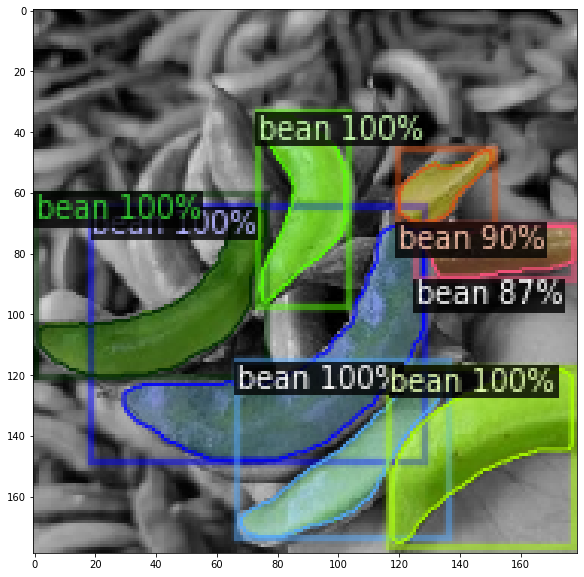

In [11]:
for d in random.sample(test_dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [12]:
import pickle

cfg_save_path = "/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean/Pigment_cfg.pickle"

#save cfg for using test
with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

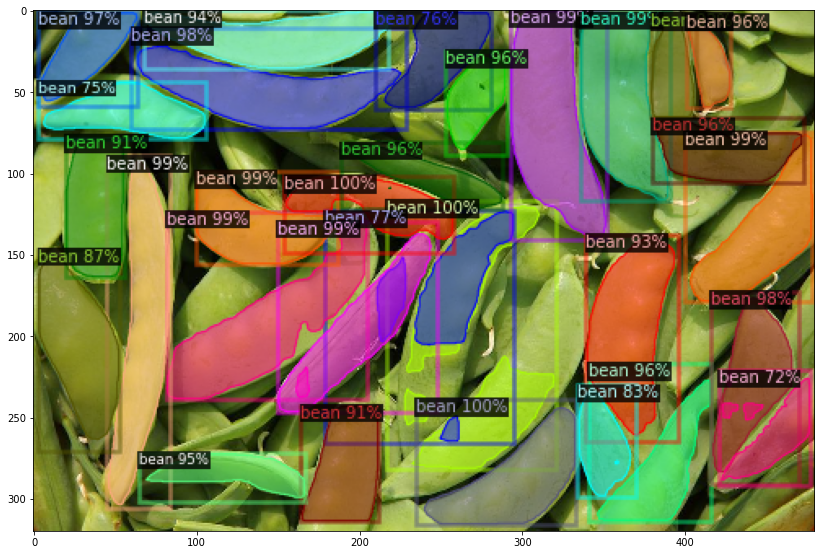

In [14]:
def on_image(image_path,predictor):
    
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata=microcontroller_metadata ,scale = 0.5,instance_mode=ColorMode.SEGMENTATION)#ColorMode.IMAGE_BW ->Gray
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14,10))
    plt.imshow(v.get_image())
    plt.show()

image_path = "/content/bean_test_2.jpg"
on_image(image_path, predictor)

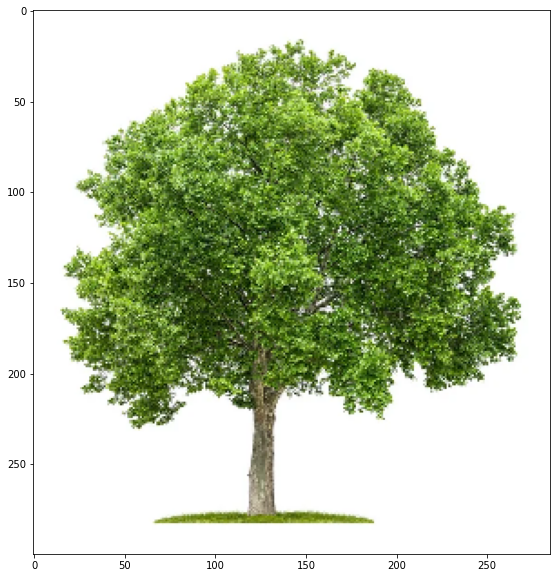

In [16]:
image_path = "/content/agac.jpg"
on_image(image_path, predictor)